In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

np.random.seed(2)

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

sns.set(style='white', context='notebook', palette='deep')

In [6]:
# Read in the data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

X_train = train.drop('label', axis=1)
y_train = train['label']

In [7]:
# Normalize
X_train = X_train / 255.
test = test / 255.

# Reshape into 4D tensors
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)

# Split the train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1, random_state=42)

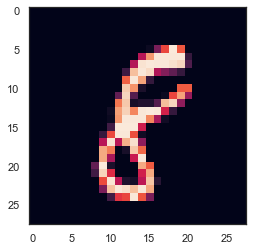

In [9]:
g = plt.imshow(X_train[0][:, :, 0])

In [4]:
# Define the model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [10]:
# Define optimizer
optimizer = RMSprop(lr=.001, rho=.9, epsilon=1e-08, decay=0.)

In [14]:
# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Define a learning rate annealer that runs every epoch
learning_rate_annealer = ReduceLROnPlateau(monitor='val_accuracy', 
                                           patience=3, 
                                           verbose=1, 
                                           factor=0.5, 
                                           min_lr=0.00001)

In [16]:
# Train the model
# Skip data augmentation for now

history = model.fit(X_train, y_train,
                    batch_size=86,
                    epochs=1,
                    validation_data=(X_val, y_val),
                    verbose=2,
                    callbacks=[learning_rate_annealer])

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 322s - loss: 0.0627 - accuracy: 0.9817 - val_loss: 0.0407 - val_accuracy: 0.9879


In [24]:
y_pred_probas = model.predict(X_val)
print("[validation] Cross entropy loss:", log_loss(y_val, y_pred_probas))
y_pred = np.argmax(y_pred_probas, axis=1)
print("[validation] Accuracy:", accuracy_score(np.argmax(y_val, axis=1), y_pred)) # Undo one-hot encoding
# todo: plot confusion matrix on validation set

[validation] Cross entropy loss: 0.04072117786608057
[validation] Accuracy: 0.9878571428571429


In [25]:
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')

In [26]:
submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), results], axis=1)
os.makedirs('output', exist_ok=True)
submission.to_csv('output/submission.csv', index=False)